# Step 3 - Runup models
In this notebook, we run wave runup models using the py-wave-runup tool coded by:

> Chris Leaman, Tomas Beuzen, & Evan B. Goldstein. (2020). chrisleaman/py-wave-runup: v0.1.10 (v0.1.10). Zenodo. https://doi.org/10.5281/zenodo.3629949

In [1]:
# Import all models
from py_wave_runup import models
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
from scipy.stats import percentileofscore
import numpy as np


## Import wave and tide data
We first import wave and tide data that were obtained in Step 1, and we report the beach slope calculated in Step 2.

In [2]:
# Define folders where wave and tide data has been stored
outdata_path = '../output/data'
images_path = '../output/images'
# Read both dataframes
waves = pd.read_csv(os.path.join(outdata_path, 'waves_complete.csv'), parse_dates=['time'])
tides = pd.read_csv(os.path.join(outdata_path,'tides.csv'), parse_dates=['dates'])
# Adjust time columns
tides['Calendar Date (UTC)'] = pd.to_datetime(tides['dates'], format='%Y-%m-%d %H:%M:%S.%f+00:00')
tides.drop(columns=['dates'],inplace=True)
waves['time'] = pd.to_datetime(waves['time'], format='%Y-%m-%d %H:%M:%S',utc=True)

Then, we merge the two datasets using the time columns. So we have a single dataframe with waves and tides.

In [3]:
# Sort both dataframes by the 'date' columns
waves.sort_values('time', inplace=True)
tides.sort_values('Calendar Date (UTC)', inplace=True)
# Merge the dataframes based on the closest date and time
df = pd.merge_asof(waves, tides, left_on='time', right_on='Calendar Date (UTC)', direction='nearest')
# Calculate the time difference in minutes and format the column
df['time_diff'] = ((df['time'] - df['Calendar Date (UTC)']).dt.total_seconds() / 60).round(2)
waves_tides=df.copy()

### Modern wave runup
First, we calculate runup for all waves with direction perpendicular to the coast. To each calculated runup, we add the corresponding tidal level. We make a list containing the slope value, repeated for the number of values in the waves_tides dataset.

In [4]:
#Make list with slope values
slope_value=0.1
slope = [slope_value] * len(waves_tides)

We then calculate the runup with different models.

In [5]:
# Inputs
VHM0 = waves_tides['VHM0'].tolist()
VTPK = waves_tides['VTPK'].tolist()
tide = waves_tides['tide'].tolist()

runup = {'Stockdon et al. (2006)': (models.Stockdon2006(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Vousdoukas et al. (2012)': (models.Vousdoukas2012(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Beuzen et al. (2019)': (models.Beuzen2019(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Holman (1986)': (models.Holman1986(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Nielsen (2009)': (models.Nielsen2009(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Ruggiero et al. (2001)': (models.Ruggiero2001(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Atkinson et al. (2017)': (models.Atkinson2017(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Senechal et al. (2011)': (models.Senechal2011(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Passarella et al. (2018)': (models.Passarella2018(Hs=VHM0, Tp=VTPK, beta=slope)).swash+tide}

# Create dataframe of runup values
R2 = pd.DataFrame(runup)
R2 = pd.merge(R2, waves_tides, left_index=True, right_index=True)
columns = ['Stockdon et al. (2006)',
           'Vousdoukas et al. (2012)',
           'Beuzen et al. (2019)',
           'Holman (1986)',
           'Nielsen (2009)',
           'Ruggiero et al. (2001)',
           'Atkinson et al. (2017)',
           'Senechal et al. (2011)',
           'Passarella et al. (2018)']

Before plotting the runup values, we filter out those that are derived from waves that are not perpendicualr to the coast, and those waves that hit at tides below MSL (as any landform would have been eroded at the next tidal cycle).

In [6]:
# Change wave angles to keep only shore-perpendicular waves
min_wave_angle=45
max_wave_angle=135

# filtering waves with direction perpendicular to the coast
R2_filter = R2[(R2['VMDR'] >= min_wave_angle) & (R2['VMDR'] <= max_wave_angle)]
R2_filter = R2_filter[(R2_filter['tide'] > 0)]

R2_filter.reset_index(drop=True, inplace=True)

Then, we plot the calculated runup values.

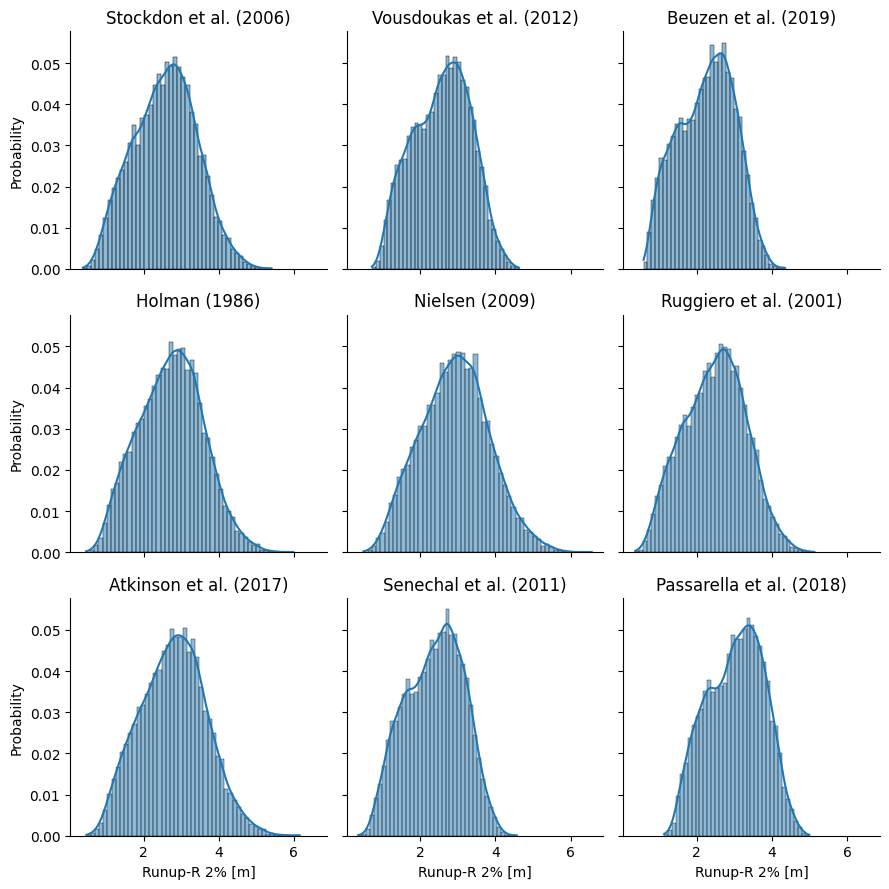

In [7]:
# Create FacetGrid object
grid = sns.FacetGrid(R2_filter.melt(value_vars=columns), col="variable", col_wrap=3, height=3)
# Plot histograms for each column
grid.map(sns.histplot, "value", kde=True, stat="probability")

for ax, col, title in zip(grid.axes.flat, columns, columns):
    ax.set_title(title)
    ax.set_xlabel('Runup-R 2% [m]')
    ax.set_ylabel('Probability')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(os.path.join(images_path,'runup_modern_all.jpg'),dpi=500)
plt.show()

### Validate wave runup
To validate the runup models, we extract the model results for the time of survey, when we measured the elevation of the swash zone and the beach cusps, which are created by wave runup.

**If no data is available from the modern shoreline, this step can be skipped**

In [8]:
# Elevation of the instantaneous swash zone 
El1 = 0.55
El1_1s=0.30

# Time of survey
survey_date_time_str = '2019-11-02 15:55:41+00:00'

First, we find the closest datapoint to our survey date and time in the runup dataframe and extract the corresponding values.

In [9]:
# Convert string to datetime object
survey_date_time = datetime.strptime(survey_date_time_str, '%Y-%m-%d %H:%M:%S%z')
# Remove timezone information to make it timezone-naive
survey_date_time = survey_date_time.replace(tzinfo=None)

# Assuming R2 is your DataFrame and it has a 'time' column with datetime objects
# Convert 'time' column to datetime if it's not already
R2['time'] = pd.to_datetime(R2['time']).dt.tz_localize(None)

# Find the row with the closest date and time
closest_datapoint = R2.loc[(R2['time'] - survey_date_time).abs().idxmin()]

# Save data to CSV file
closest_datapoint.to_csv(os.path.join(outdata_path, 'runup_survey_time.csv'), index=True)

closest_datapoint

Stockdon et al. (2006)                       0.591903
Vousdoukas et al. (2012)                     0.642463
Beuzen et al. (2019)                         0.339068
Holman (1986)                                0.756147
Nielsen (2009)                               0.916712
Ruggiero et al. (2001)                       0.505715
Atkinson et al. (2017)                       0.810698
Senechal et al. (2011)                       0.542318
Passarella et al. (2018)                     1.142363
time                              2019-11-02 15:00:00
VHM0                                             1.38
VTPK                                             8.28
VMDR                                        29.410004
tide                                           -0.532
Calendar Date (UTC)         2019-11-02 15:00:00+00:00
time_diff                                         0.0
Name: 78413, dtype: object

Then, we plot the elevation of observed runup proxies vs modelled runup.

/var/folders/yt/ph2vgh2x537141y3jl9pwcc00000gn/T/ipykernel_12839/1896565169.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(combined_data, labels=['Modelled runup', 'Observed swash'], vert=True)


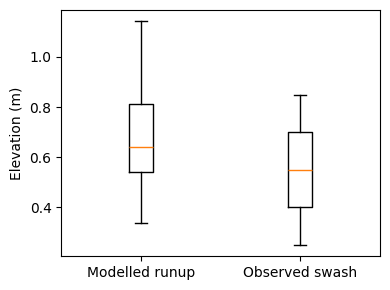

In [10]:
columns = ['Stockdon et al. (2006)',
           'Vousdoukas et al. (2012)',
           'Beuzen et al. (2019)',
           'Holman (1986)',
           'Nielsen (2009)',
           'Ruggiero et al. (2001)',
           'Atkinson et al. (2017)',
           'Senechal et al. (2011)',
           'Passarella et al. (2018)']
R2_values = closest_datapoint[columns].tolist()
# Combine the values with the swash zone data and 1-sigma range
combined_data = [R2_values, [El1 - El1_1s, El1 + El1_1s]]
# Plotting the box plot
plt.figure(figsize=(4, 3))
plt.boxplot(combined_data, labels=['Modelled runup', 'Observed swash'], vert=True)
plt.ylabel('Elevation (m)')
plt.tight_layout()
plt.savefig(os.path.join(images_path,'benchmark_runup.jpg'),dpi=500)
plt.show()

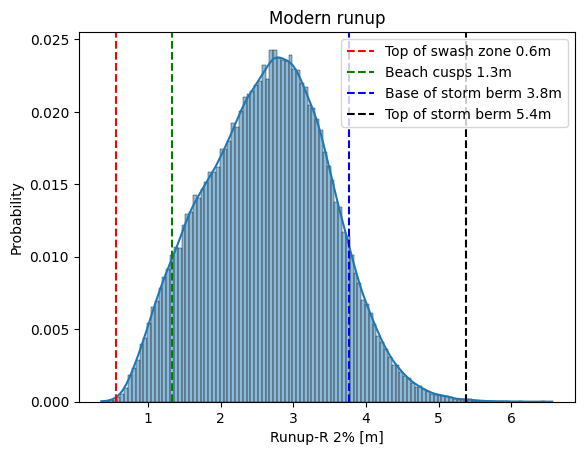

In [22]:
overall_data = R2_filter.melt(value_vars=columns)['value']

#Define elevations of key points on the beach
Top_swash=0.55
Beach_cusps=1.33
Base_berm=3.77
Top_berm=5.38
                                           
# Create the 'Overall' plot
sns.histplot(data=overall_data, kde=True, stat="probability")
plt.title('Modern runup') 
plt.xlabel('Runup-R 2% [m]')
plt.ylabel('Probability')

# Add lines for average and confidence interval
plt.axvline(Top_swash, color='r', linestyle='--', label=f'Top of swash zone {Top_swash:.1f}m')
plt.axvline(Beach_cusps, color='g', linestyle='--', label=f'Beach cusps {Beach_cusps:.1f}m')
plt.axvline(Base_berm, color='b', linestyle='--', label=f'Base of storm berm {Base_berm:.1f}m')
plt.axvline(Top_berm, color='k', linestyle='--', label=f'Top of storm berm {Top_berm:.1f}m')

# Set legend in the lower right corner
plt.legend(loc='upper right')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

In [12]:
overall_data.to_csv(os.path.join(outdata_path, 'runup_modern_total.csv'), index=True)

## Paleo wave runup
To calculate wave runup in the past, we need to go beyond the instrumental record. For this, we need to assume that each wave condition in the instrumental record might have happened during different tidal stages, and that wave directions might have varied. Therefore we resample the waves and tides data to produce one million possible combinations. As also the slope may have slightly varied in such long timescales, we generate a normal random dataset of slope values that are between plus minus 0.01 from the original slope.

In [13]:
# NUmber of wave/tide conditions in the dataset
n=1000000

# filter waves and tides datasets
waves_filter= waves[(waves['VMDR'] >= min_wave_angle) & (waves['VMDR'] <= max_wave_angle)]
waves_filter.reset_index(drop=True, inplace=True)

tides_filter=tides[(tides['tide'] > 0)]
tides_filter.reset_index(drop=True, inplace=True)

# Create a synthetic wave/tide dataset
sampled_tides = tides_filter.sample(n=n, replace=True)
sampled_waves = waves_filter.sample(n=n, replace=True)

# Sample pairs of VHM0 and VTPK from waves_filter
sampled_waves = waves_filter[['VHM0', 'VTPK']].sample(n=n, replace=True, random_state=1).reset_index(drop=True)
# Sample tide values from tides_filter
sampled_tide = tides_filter['tide'].sample(n=n, replace=True, random_state=1).reset_index(drop=True)
# Combine the sampled data into a new dataframe
synth_ensamble = pd.concat([sampled_waves, sampled_tide], axis=1)

# Generate the dataset
slope = np.random.normal(loc=slope_value, scale=0.01, size=n)

Then, we run the runup models with this new dataset. 

**This might take a long time to run**

In [14]:
# Inputs
VHM0 = synth_ensamble['VHM0'].tolist()
VTPK = synth_ensamble['VTPK'].tolist()
tide = synth_ensamble['tide'].tolist()

runup = {'Stockdon et al. (2006)': (models.Stockdon2006(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Vousdoukas et al. (2012)': (models.Vousdoukas2012(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Beuzen et al. (2019)': (models.Beuzen2019(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Holman (1986)': (models.Holman1986(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Nielsen (2009)': (models.Nielsen2009(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Ruggiero et al. (2001)': (models.Ruggiero2001(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Atkinson et al. (2017)': (models.Atkinson2017(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Senechal et al. (2011)': (models.Senechal2011(Hs=VHM0, Tp=VTPK, beta=slope)).R2+tide,
        'Passarella et al. (2018)': (models.Passarella2018(Hs=VHM0, Tp=VTPK, beta=slope)).swash+tide}

# Create dataframe of runup values
R2_synth = pd.DataFrame(runup)
columns = ['Stockdon et al. (2006)',
           'Vousdoukas et al. (2012)',
           'Beuzen et al. (2019)',
           'Holman (1986)',
           'Nielsen (2009)',
           'Ruggiero et al. (2001)',
           'Atkinson et al. (2017)',
           'Senechal et al. (2011)',
           'Passarella et al. (2018)']



For this synthetic dataset, we plot the distribution and the 5th-50th-95th percentiles.

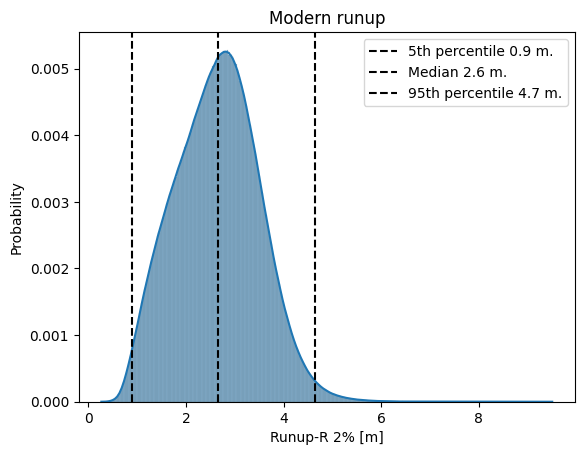

In [26]:
overall_synth = R2_synth.melt(value_vars=columns)['value']

# Calculate percentiles of key points
percentiles=overall_synth.quantile([0.01, 0.5, 0.99])

# Create the 'Overall' plot
sns.histplot(data=overall_synth, kde=True, stat="probability")
plt.title('Modern runup') 
plt.xlabel('Runup-R 2% [m]')
plt.ylabel('Probability')

# Add lines for average and confidence interval
plt.axvline(percentiles.loc[0.01], color='k', linestyle='--', label=f'5th percentile {percentiles.loc[0.01]:.1f} m.')
plt.axvline(percentiles.loc[0.5], color='k', linestyle='--', label=f'Median {percentiles.loc[0.5]:.1f} m.')
plt.axvline(percentiles.loc[0.99], color='k', linestyle='--', label=f'95th percentile {percentiles.loc[0.99]:.1f} m.')

# Set legend in the lower right corner
plt.legend(loc='upper right')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

In [18]:
overall_synth.to_csv(os.path.join(outdata_path, 'runup_synthetic.csv'), index=True)